In [198]:
import numpy as np
import numba as nb
import time

# Introduction 
We want to minimize the function $z = b ( 1 - e^{\frac{1}{2} w (x^2 + y^2)}) + \frac{1}{2} q (-x^3 +y)^2$. For starting just have a look to function:

In [92]:
b = 20
q = 1/10
w = 10

#function to be minimized
def f(x, y):
    return b*(1-np.exp( - (1/2) * w * (x**2 + y**2))) + (q/2) * ( - x**3 + y)**2

#derivative w.r.t x
def fx(x, y):
    return b * np.exp(-1/2 * w * (x**2 + y**2)) * w * x - 3 * q * x**2 *(-x**3 + y)

#derivative w.r.t y
def fy(x, y):
    return b * np.exp(-1/2 * w * (x**2 + y**2)) * w * y + q *(-x**3 + y)

#gradient
def grad_f(param):
    x = param[0]
    y = param[1]
    return [fx(x,y), fy(x,y)]
    

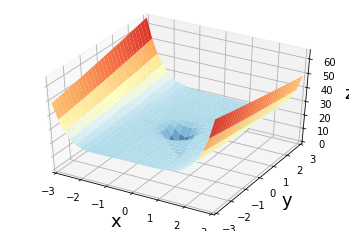

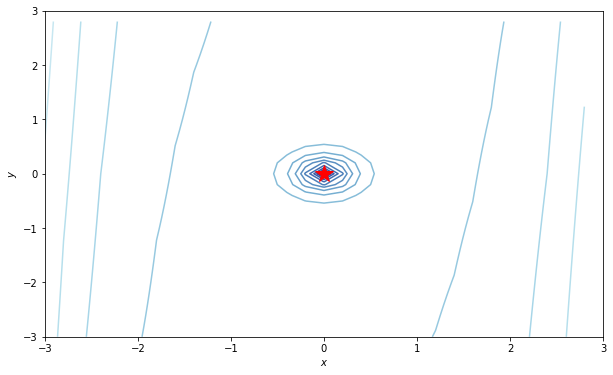

In [93]:
#Make 3D plots
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
#from matplotlib import animation
from IPython.display import HTML
from matplotlib.colors import LogNorm
#from itertools import zip_longest


#Define function for plotting 

def plot_surface(x, y, z, azim=-60, elev=40, dist=10, cmap="RdYlBu_r"):

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    plot_args = {'rstride': 1, 'cstride': 1, 'cmap':cmap,
             'linewidth': 20, 'antialiased': True,
             'vmin': 0, 'vmax': 65}
    ax.plot_surface(x, y, z, **plot_args)
    ax.view_init(azim=azim, elev=elev)
    ax.dist=dist
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.set_zlim(0, 65)
    
    ax.set_xlabel("x", fontsize=18)
    ax.set_ylabel("y", fontsize=18)
    ax.set_zlabel("z", fontsize=18)
    return fig, ax;

def contour_function():
    #plot beales function
    x, y = np.meshgrid(np.arange(-3, 3, 0.2), np.arange(-3, 3, 0.2))
    fig, ax = plt.subplots(figsize=(10, 6))
    z=f(x,y)
    cax = ax.contour(x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap="RdYlBu_r")
    ax.plot(0,0, 'r*', markersize=18)

    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

    ax.set_xlim((-3, 3))
    ax.set_ylim((-3, 3))
    
    return fig,ax

x, y = np.mgrid[-3:3:31j, -3:3:31j]
fig1,ax1=plot_surface(x,y,f(x,y))
fig4,ax4 =contour_function()
plt.show()



# About initial conditions and learnign rate
We can see our function is flat in a big area of the domain, so the risk is that choosing a initial point in that area the algorithms will do not improve the solution. Let see it.

In [94]:
#This writes a simple gradient descent and gradient descent+ momentum

def gd(grad, init, n_epochs=1000, eta=10**-4, noise_strength=0):
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1,2])
    param_traj[0,]=init
    v=0;
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        v=eta*(np.array(grad(params))+noise)
        params=params-v
        param_traj[j+1,]=params
    return param_traj


def gd_with_mom(grad, init, n_epochs=5000, eta=10**-4, gamma=0.9,noise_strength=0):
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1,2])
    param_traj[0,]=init
    v=0
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        v=gamma*v+eta*(np.array(grad(params))+noise)
        params=params-v
        param_traj[j+1,]=params
    return param_traj


def overlay_trajectory_contour(ax,trajectory, label,color='k',lw=2):
    xs=trajectory[:,0]
    ys=trajectory[:,1]
    ax.plot(xs,ys, color, label=label,lw=lw)
    return ax;

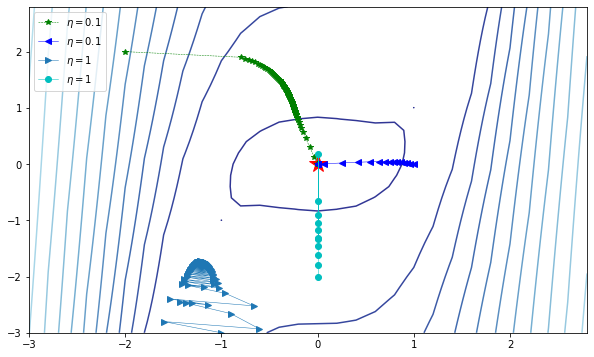

In [116]:
# Investigate effect of learning rate in GD
plt.close()
a,b = 1.0,1.0
x, y = np.meshgrid(np.arange(-3, 3, 0.2), np.arange(-3, 3, 0.2))
fig, ax = plt.subplots(figsize=(10, 6))
z=f(x,y)
ax.contour(x, y, z, levels=np.logspace(0.0, 5, 35), norm=LogNorm(), cmap="RdYlBu_r")
ax.plot(0,0, 'r*', markersize=18)

#initial point
init1=[-2,2]
init2=[1,0]
init3=[-1,-3]
init4=[0,-2]
eta1=0.1
eta2=0.1
eta3=1
eta4=1
gd_1=gd(grad_f,init1, n_epochs=100, eta=eta1)
gd_2=gd(grad_f,init2, n_epochs=100, eta=eta2)
gd_3=gd(grad_f,init3, n_epochs=100, eta=eta3)
gd_4=gd(grad_f,init4, n_epochs=10, eta=eta4)
#print(gd_1)
overlay_trajectory_contour(ax,gd_1,'$\eta=$%s'% eta1,'g--*', lw=0.5)
overlay_trajectory_contour(ax,gd_2,'$\eta=$%s'% eta2,'b-<', lw=0.5)
overlay_trajectory_contour(ax,gd_3,'$\eta=$%s'% eta3,'->', lw=0.5)
overlay_trajectory_contour(ax,gd_4,'$\eta=$%s'% eta4,'c-o', lw=0.5)
plt.legend(loc=2)
plt.show()
#fig.savefig("GD3regimes.pdf", bbox_inches='tight')

We can see that the fact that the learning rate $\eta$ is constant is a strong limitation for our algorithm: we have to choose a learning rate for every starting point and not always it is possibile to find it. Let see now how the algorithm works adding stocasticity.

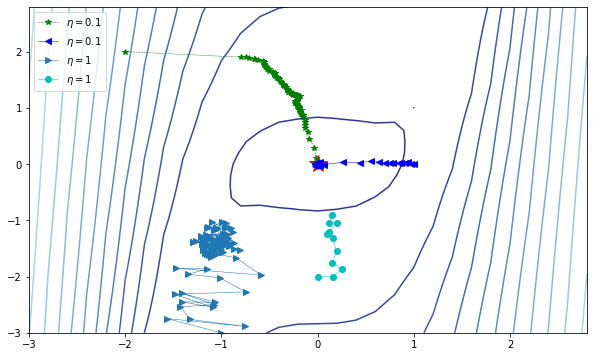

In [123]:
# Investigate effect of learning rate in GD
plt.close()
a,b = 1.0,1.0
x, y = np.meshgrid(np.arange(-3, 3, 0.2), np.arange(-3, 3, 0.2))
fig, ax = plt.subplots(figsize=(10, 6))
z=f(x,y)
ax.contour(x, y, z, levels=np.logspace(0.0, 5, 35), norm=LogNorm(), cmap="RdYlBu_r")
ax.plot(0,0, 'r*', markersize=18)

#initial point
init1=[-2,2]
init2=[1,0]
init3=[-1,-3]
init4=[0,-2]
eta1=0.1
eta2=0.1
eta3=1
eta4=1
gd_1=gd(grad_f,init1, n_epochs=100, eta=eta1, noise_strength=0.1)
gd_2=gd(grad_f,init2, n_epochs=100, eta=eta2, noise_strength=0.1)
gd_3=gd(grad_f,init3, n_epochs=100, eta=eta3, noise_strength=0.1)
gd_4=gd(grad_f,init4, n_epochs=10, eta=eta4, noise_strength=0.1)
#print(gd_1)
overlay_trajectory_contour(ax,gd_1,'$\eta=$%s'% eta1,'g--*', lw=0.5)
overlay_trajectory_contour(ax,gd_2,'$\eta=$%s'% eta2,'b-<', lw=0.5)
overlay_trajectory_contour(ax,gd_3,'$\eta=$%s'% eta3,'->', lw=0.5)
overlay_trajectory_contour(ax,gd_4,'$\eta=$%s'% eta4,'c-o', lw=0.5)
plt.legend(loc=2)
plt.show()
#fig.savefig("GD3regimes.pdf", bbox_inches='tight')

Nothing changed in general, we expect this from the fact that our function contains only one minima and we are not in a situation where we need to escape from some local minima. Let's see now how our algorithm changes adding momentum

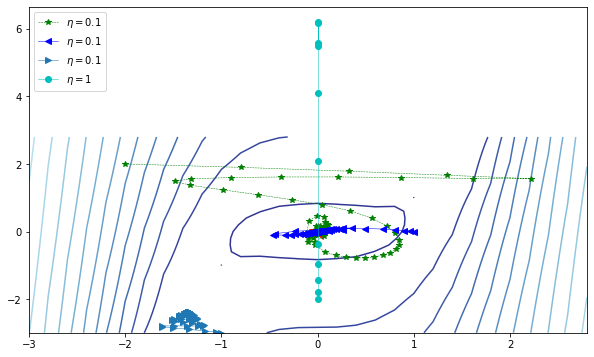

In [138]:
# Investigate effect of learning rate in GD
plt.close()
a,b = 1.0,1.0
x, y = np.meshgrid(np.arange(-3, 3, 0.2), np.arange(-3, 3, 0.2))
fig, ax = plt.subplots(figsize=(10, 6))
z=f(x,y)
ax.contour(x, y, z, levels=np.logspace(0.0, 5, 35), norm=LogNorm(), cmap="RdYlBu_r")
ax.plot(0,0, 'r*', markersize=18)

#initial point
init1=[-2,2]
init2=[1,0]
init3=[-1,-3]
init4=[0,-2]
eta1=0.1
eta2=0.1
eta3=0.1
eta4=0.1
gd_1=gd_with_mom(grad_f,init1, n_epochs=100, eta=eta1)
gd_2=gd_with_mom(grad_f,init2, n_epochs=100, eta=eta2)
gd_3=gd_with_mom(grad_f,init3, n_epochs=100, eta=eta3)
gd_4=gd_with_mom(grad_f,init4, n_epochs=10, eta=eta4)
#print(gd_1)
overlay_trajectory_contour(ax,gd_1,'$\eta=$%s'% eta1,'g--*', lw=0.5)
overlay_trajectory_contour(ax,gd_2,'$\eta=$%s'% eta2,'b-<', lw=0.5)
overlay_trajectory_contour(ax,gd_3,'$\eta=$%s'% eta3,'->', lw=0.5)
overlay_trajectory_contour(ax,gd_4,'$\eta=$%s'% eta4,'c-o', lw=0.5)
plt.legend(loc=2)
plt.show()
#fig.savefig("GD3regimes.pdf", bbox_inches='tight')

Adding the momentum we see that the algorithm is less stable, adding a mass is like our algorithm describe the motion of a ball on a plane given by the function.

# Statystical analysis
After choosen the best parameters for each algorithms we want to compare them in terms of accuracy and computation time.

For each algorithm we will prove various parameter values and we choose that one minimizes the mean squared distance of all found points for each condition.

Let be $Q$ the set of all initial conditions and $A: Q \rightarrow \mathbb{R}$ our algorithm function that starting from the initial point find the value for wich the function is at minima. So we define out test index $t$ as:

$t = \frac{\sum_{x \in Q} |A(x)|^2}{|Q|}$

Let start with the 'vanilla' GD:

In [141]:
#First we change the functions gd and gd_with_mom to make tham more fast

def gd(grad, init, n_epochs=10000, eta=10**-4):
    params=init
    v=0;
    for j in range(n_epochs):
        v=eta*np.array(grad(params))
        params=params-v
    return params

def gd_with_mom(grad, init, n_epochs=10000, eta=10**-4, gamma=0.9):
    params=init
    v=0
    for j in range(n_epochs):
        v=gamma*v+eta*np.array(grad(params))
        params=params-v
    return params

In [164]:
#best parameters for 'vannila' gd algorithm

#defining all possibile starting point spaced by 1
x, y = np.meshgrid(np.arange(-3, 3, 1), np.arange(-3, 3, 1))
starting_points = np.array([[i,j] for i,j in zip(np.concatenate(x),np.concatenate(y))])


test = []
for n_epochs in np.logspace(2,4,3).astype(int):
    for eta in np.logspace(-6,-2,5):
        gd_1 = []
        for init1 in starting_points:
            gd_1.append(gd(grad_f,init1, n_epochs=n_epochs, eta=eta))
    
        test.append((np.array(gd_1)**2).sum(axis = 1).mean())


In [165]:
np.array(test)

array([6.32491125, 6.25352272, 5.79098822, 4.70720958, 3.6088476 ,
       6.25355639, 5.79207759, 4.71154895, 3.61493467, 2.14684418,
       5.7921861 , 4.71197924, 3.61543239, 2.15102548, 2.03961675])

We see the best learning rate is 0.01 (if we increase in logarithmic scale the learning rate to 0.1 the results will be unstable and the algorithm will return nan numbers). Let see now, with this learning range how the acccuracy change changing the number of iterations.

In [179]:
#best parameters for 'vannila' gd algorithm

#defining all possibile starting point spaced by 1
x, y = np.meshgrid(np.arange(-3, 3, 1), np.arange(-3, 3, 1))
starting_points = np.array([[i,j] for i,j in zip(np.concatenate(x),np.concatenate(y))])


test = []
for n_epochs in np.logspace(1,6,6).astype(int):
    gd_1 = []
    for init1 in starting_points:
        gd_1.append(gd(grad_f,init1, n_epochs=n_epochs, eta=10**-2))
    
    test.append((np.array(gd_1)**2).sum(axis = 1).mean())



In [180]:
gd_test = np.array(test)
gd_test

array([4.6562612 , 3.6088476 , 2.14684418, 2.03961675, 1.88146105,
       1.73806858])

Repeat the same think for the gd with momentum

In [175]:
#best parameters for gd algorithm with momentum

#defining all possibile starting point spaced by 1
x, y = np.meshgrid(np.arange(-3, 3, 1), np.arange(-3, 3, 1))
starting_points = np.array([[i,j] for i,j in zip(np.concatenate(x),np.concatenate(y))])


test = []
for n_epochs in np.logspace(2,4,3).astype(int):
    for eta in np.logspace(-6,-2,5):
        gd_1 = []
        for init1 in starting_points:
            gd_1.append(gd_with_mom(grad_f,init1, n_epochs=n_epochs, eta=eta))
    
        test.append((np.array(gd_1)**2).sum(axis = 1).mean())



In [176]:
np.array(test)

array([6.25979408, 5.80419614, 4.65183039, 3.32655396, 1.83570764,
       5.7931846 , 4.70734892, 3.60887061, 1.87716213, 1.72916536,
       4.71156999, 3.61496926, 2.1445694 , 1.76872355, 1.49906288])

Also in this case the best learning rate is 0.01 (if we increase in logarithmic scale the learning rate to 0.1 the results will be unstable and the algorithm will return nan numbers). Let see now, with this learning range how the accuracy change changing the number of iterations.

In [181]:
#best parameters for gd algorithm with momentum

#defining all possibile starting point spaced by 1
x, y = np.meshgrid(np.arange(-3, 3, 1), np.arange(-3, 3, 1))
starting_points = np.array([[i,j] for i,j in zip(np.concatenate(x),np.concatenate(y))])


test = []
for n_epochs in np.logspace(1,6,6).astype(int):
    gd_1 = []
    for init1 in starting_points:
        gd_1.append(gd_with_mom(grad_f,init1, n_epochs=n_epochs, eta=10**-2))
    
    test.append((np.array(gd_1)**2).sum(axis = 1).mean())

In [182]:
gdm_test = np.array(test)
gdm_test

array([4.22822605, 1.83570764, 1.72916536, 1.49906288, 1.49699346,
       1.30845556])

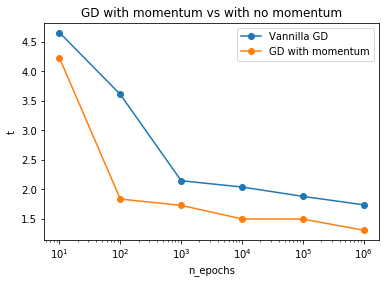

In [196]:
plt.plot(np.logspace(1,6,6),gd_test, '-o',label = 'Vannilla GD')
plt.plot(np.logspace(1,6,6), gdm_test, '-o',label = 'GD with momentum')
plt.xlabel('n_epochs')
plt.ylabel('t')
plt.xscale('log')
plt.title('GD with momentum vs with no momentum')
plt.legend()
plt.show()

Let compare the computation time of the solution:

In [201]:
%%timeit
#vanilla gd
gd_1 = []
for init1 in starting_points:
            gd_1.append(gd(grad_f,init1, n_epochs=10**4, eta=0.01))

7.65 s ± 906 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [202]:
%%timeit
#vanilla gd
gd_1 = []
for init1 in starting_points:
            gd_1.append(gd_with_mom(grad_f,init1, n_epochs=10**4, eta=0.01))

8.62 s ± 954 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


The difference in code between the two algorithms is the addition of the memory term 'gamma*v' that will increase the execution time of the code but will archive more accurate results